In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import load_metadata, load_footsteps

Define Sensor Resolution & Sampling Frequency

In [2]:
fs = 100 # Hz
rx = 0.5/100 # m 
ry = 0.5/100 # m

Load Preprocessed Data for One Trial

In [3]:
# selected trial
participant_id = 9
shoe_type = 'P1'
walk_condition = 'W1'

In [4]:
data = load_footsteps(participant_id, shoe_type, walk_condition, pipeline = 1) 
metadata = load_metadata(participant_id,shoe_type,walk_condition)

In [5]:
# get example footstep
iFootstep = 10
footstep = data[iFootstep]
print(metadata.iloc[iFootstep])


ParticipantID               9
Footwear                   P1
Speed                      W1
FootstepID                 10
PassID                      2
StartFrame               1434
EndFrame                 1523
Ymin                       28
Ymax                       92
Xmin                      170
Xmax                      198
Orientation                 1
Side                    Right
Standing                    0
Incomplete                  0
Rscore               0.376493
Outlier                     0
Exclude                     0
RotationAngle        5.969352
FootLength               64.0
FootWidth                27.0
MeanGRF          25040.851485
Name: 10, dtype: object


Peak Pressure Image

In [6]:
def compute_PPI(footstep): 
    peak_pressure = footstep.max(0) 
    return peak_pressure

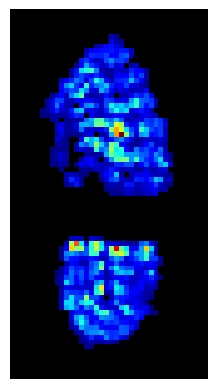

In [7]:
PPI = compute_PPI(footstep)

# create colormap
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

# plot image
plt.imshow(PPI,cmap = cmap)
plt.axis('off')
plt.show()

Ground Reaction Force

In [8]:
def compute_GRF(footstep): 
    GRF = footstep.sum((1,2)) # take sum over x & y for each time point

    # apply 2nd order low-pass butterworth filter with a cut-off frequency of 20Hz
    order, cutoff, sf = 2, 20, 100
    b, a = butter(order, (2*cutoff)/sf, 'low')

    GRF = filtfilt(b, a, GRF,method = 'gust')
    return GRF

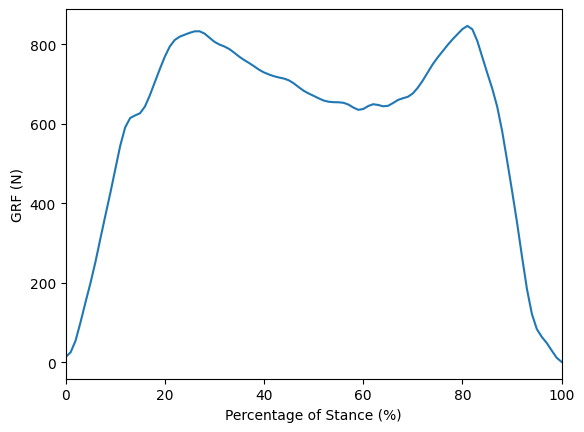

In [9]:
GRF = compute_GRF(footstep)

# since the Pipeline 1 version of the footsteps retains the original sensor resolution (0.25 cm^2/pixel) 
# and amplitude units (kPa),  we can convert the GRF into Newtons
pix_per_m2 = 1/(rx * ry)
GRF = GRF * 1000/pix_per_m2

plt.plot(np.arange(101),GRF)
plt.xlim((0,100))
plt.xlabel('Percentage of Stance (%)')
plt.ylabel('GRF (N)')
plt.show()

Center of Pressure

In [10]:
def compute_COP(footstep):
    AP_COP = ((footstep.sum(2)*np.arange(0,footstep.shape[1]))/footstep.sum((1,2))[:,np.newaxis]).sum(1)
    ML_COP = ((footstep.sum(1)*np.arange(0,footstep.shape[2]))/footstep.sum((1,2))[:,np.newaxis]).sum(1)

    AP_COP[np.isnan(AP_COP) | np.isinf(AP_COP)] = 0 
    ML_COP[np.isnan(ML_COP) | np.isinf(ML_COP)] = 0 

    # center the time series (so that COP is with respect to foot center)
    AP_COP = AP_COP - np.nanmean(AP_COP)
    ML_COP = ML_COP - np.nanmean(ML_COP)
    
    # apply 2nd order low-pass butterworth filter with a cut-off frequency of 20Hz
    order, cutoff, sf = 2, 20, 100
    b, a = butter(order, (2*cutoff)/sf, 'low')

    AP_COP =  filtfilt(b, a, AP_COP,method = 'gust')
    ML_COP =  filtfilt(b, a, ML_COP,method = 'gust')

    return np.stack((AP_COP,ML_COP))

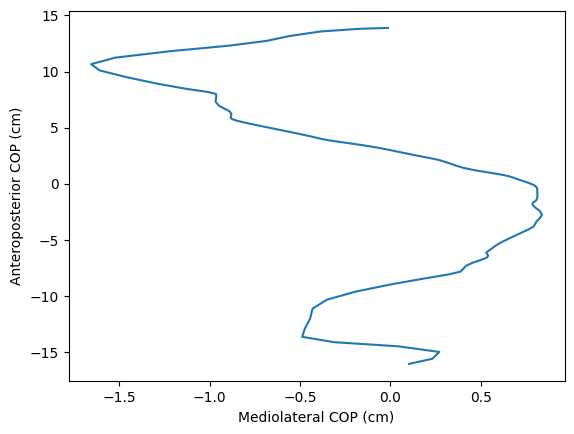

In [11]:
AP_COP,ML_COP = compute_COP(footstep)

# since the Pipeline 1 version of the footsteps retains the original sensor resolution, 
# we can convert the COP into units of centimeters
AP_COP = AP_COP*ry*100
ML_COP = ML_COP*rx*100

plt.plot(ML_COP,AP_COP)
plt.xlabel('Mediolateral COP (cm)')
plt.ylabel('Anteroposterior COP (cm)')
plt.show()


Spatiotemporal Gait Parameters

In [12]:
# break trial up into individual passes across tiles
pass_start = np.insert(np.where(np.diff(metadata.Orientation) != 0)[0]+1,0,0)
pass_end = np.append(pass_start[1:],metadata.shape[0])

# calculate step length, width and time 
step_width = []
step_length = []
step_time = []

# loop over all passes
for start_idx,end_idx in zip(pass_start,pass_end):
    pass_metadata = metadata[start_idx:end_idx]

    # get all valid consecutive footstep pairs in pass
    n = end_idx - start_idx
    pairs = np.stack((np.arange(0,n-1),np.arange(1,n)))
    valid_idx = np.where(pass_metadata['Outlier'] == 0)[0]
    pairs = pairs[:,np.isin(pairs[0],valid_idx) & np.isin(pairs[1],valid_idx)]

    # compute step length, width, and time for each pair of steps
    for i,j in pairs.T:

        if not(pass_metadata['Side'].iloc[i] == pass_metadata['Side'].iloc[j]): # make pair includes one left and one right footstep

            # step time (heel strike to heel strike)
            delta_t = pass_metadata['StartFrame'].iloc[i] - pass_metadata['StartFrame'].iloc[j]
            delta_t = abs(delta_t/fs)

            # get bounding box centroids
            centroid_i = np.array([np.mean((pass_metadata['Ymin'].iloc[i],pass_metadata['Ymax'].iloc[i])),np.mean((pass_metadata['Xmin'].iloc[i],pass_metadata['Xmax'].iloc[i]))])
            centroid_j = np.array([np.mean((pass_metadata['Ymin'].iloc[j],pass_metadata['Ymax'].iloc[j])),np.mean((pass_metadata['Xmin'].iloc[j],pass_metadata['Xmax'].iloc[j]))])

            # step width
            delta_w = centroid_j[1] - centroid_i[1]
            delta_w = abs(delta_w*rx)

            # step length
            delta_l = centroid_j[0] - centroid_i[0]
            delta_l = abs(delta_l*rx)

            step_time.append(delta_t)
            step_width.append(delta_w)
            step_length.append(delta_l)

step_length = np.array(step_length)
step_width = np.array(step_width)
step_time = np.array(step_time)

# compute gait speed and cadence
gait_speed = step_length/step_time
cadence = 60/step_time 

# get foot rotation angle from metadata
valid_idx = metadata['Outlier'] == 0
left_foot_angle = -metadata['RotationAngle'][valid_idx & (metadata['Side'] == 'Left')] # negate to get angle with respect to body's midline
right_foot_angle = metadata['RotationAngle'][valid_idx & (metadata['Side'] == 'Right')]

print('Average Step Length:',np.round(step_length.mean(0),2),'m')
print('Average Step Width:',np.round(step_width.mean(0),2),'m')
print('Average Step Time:',np.round(step_time.mean(0),2),'s')
print('Average Gait Speed:',np.round(gait_speed.mean(0),2),'m/s')
print('Average Cadence:',np.round(cadence.mean(0),1),'steps/min')
print('Average Left Toe-Out Angle:',-np.round(left_foot_angle.mean(0),1),u'\N{DEGREE SIGN}')
print('Average Right Toe-Out Angle:',np.round(right_foot_angle.mean(0),1),u'\N{DEGREE SIGN}')

Average Step Length: 0.73 m
Average Step Width: 0.09 m
Average Step Time: 0.66 s
Average Gait Speed: 1.1 m/s
Average Cadence: 91.2 steps/min
Average Left Toe-Out Angle: 2.9 °
Average Right Toe-Out Angle: 2.2 °
